## =================================
## FINAL PREDICTION PIPELINE SCRIPT
## =================================

In [3]:
import joblib
import tensorflow as tf
import numpy as np
import librosa
import scipy.stats
import warnings
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

In [6]:
# --- 1. SETUP: Load All Saved Components ---
print("Loading pipeline components...")

# Define the path to your saved models
# '../' goes up one directory from 'Training' to the project root
save_path = "../backend/export/"

# Load Router components
router_model = joblib.load(os.path.join(save_path, "router_model.joblib"))
scaler = joblib.load(os.path.join(save_path, "router_scaler.joblib"))
encoder = joblib.load(os.path.join(save_path, "router_encoder.joblib"))

# Load High-Energy components
specialist_high = tf.keras.models.load_model(os.path.join(save_path, "specialist_high.keras"))
scaler_h = joblib.load(os.path.join(save_path, "scaler_h.joblib"))
le_high = joblib.load(os.path.join(save_path, "le_high.joblib"))

# Load Low-Energy components
specialist_low = tf.keras.models.load_model(os.path.join(save_path, "specialist_low.keras"))
scaler_l = joblib.load(os.path.join(save_path, "scaler_l.joblib"))
le_low = joblib.load(os.path.join(save_path, "le_low.joblib"))

print("All components loaded successfully.")

Loading pipeline components...


I0000 00:00:1754807554.424182  197095 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2240 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


All components loaded successfully.


In [3]:
# --- 2. FEATURE EXTRACTION FUNCTION ---
# This is the same function you created at the beginning of the project
def extract(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        features = []
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_features = np.concatenate([mfcc, mfcc_delta, mfcc_delta2], axis=0)
        for row in mfcc_features:
            features.extend([np.mean(row), np.std(row), scipy.stats.skew(row), scipy.stats.kurtosis(row)])
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for row in chroma:
            features.extend([np.mean(row), np.std(row)])
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        for row in mel_db:
            features.extend([np.mean(row), np.std(row)])
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        for row in contrast:
            features.extend([np.mean(row), np.std(row)])
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        for row in tonnetz:
            features.extend([np.mean(row), np.std(row)])
        zcr = librosa.feature.zero_crossing_rate(y)
        features.extend([np.mean(zcr), np.std(zcr)])
        rmse = librosa.feature.rms(y=y)
        features.extend([np.mean(rmse), np.std(rmse)])
        return np.array(features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [4]:
# --- 3. THE PIPELINE PREDICTION FUNCTION ---
def predict_emotion_pipeline(file_path):
    """
    Takes an audio file path and predicts the emotion using the full pipeline.
    """
    features = extract(file_path)
    if features is None:
        return "Could not process audio file."
    
    features = features.reshape(1, -1)

    # Router Stage
    scaled_features_router = scaler.transform(features)
    energy_pred_encoded = router_model.predict(scaled_features_router)[0]
    energy_pred_text = encoder.classes_[energy_pred_encoded]
    print(f"Router Decision: Emotion is '{energy_pred_text}' energy.")

    # Specialist Stage
    if energy_pred_text == 'high':
        scaled_features_specialist = scaler_h.transform(features)
        reshaped_features = scaled_features_specialist.reshape(1, -1, 1)
        final_pred_encoded = np.argmax(specialist_high.predict(reshaped_features, verbose=0))
        final_emotion = le_high.classes_[final_pred_encoded]
    else:
        scaled_features_specialist = scaler_l.transform(features)
        reshaped_features = scaled_features_specialist.reshape(1, -1, 1)
        final_pred_encoded = np.argmax(specialist_low.predict(reshaped_features, verbose=0))
        final_emotion = le_low.classes_[final_pred_encoded]

    return final_emotion

In [22]:
# --- 4. EXAMPLE USAGE ---
# Load your original data_path.csv to get a file path for testing
df = pd.read_csv("data_path.csv")
df = df.rename(columns={"Path": "speech", "Emotions": "label"})

# Select a random audio file to test the pipeline
test_file_path = df['speech'].sample(1).iloc[0]
actual_emotion = df[df['speech'] == test_file_path]['label'].iloc[0]

print("\n" + "="*40)
print(f"Testing with file: {test_file_path.split('/')[-1]}")
print(f"Actual Emotion: {actual_emotion}")
print("."*40)

# Get the pipeline's prediction
predicted_emotion = predict_emotion_pipeline(test_file_path)

print("."*40)
print(f"FINAL PREDICTION: The emotion is '{predicted_emotion}'.")
print("="*40)


Testing with file: 1.2.neutral-03.wav
Actual Emotion: neutral
........................................
Router Decision: Emotion is 'low' energy.
........................................
FINAL PREDICTION: The emotion is 'sad'.


In [26]:
# --- 1. Load the Original Full Dataset ---
X = joblib.load("features.joblib")
y = joblib.load("labels.joblib") # This contains the original 8 text labels

# --- 2. Perform the EXACT Same Train-Test Split ---
# Using random_state=42 ensures this split is identical to the one used for training.
_, X_test, _, y_test_raw = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Test data (X_test, y_test_raw) created successfully.")

Test data (X_test, y_test_raw) created successfully.


Running final evaluation on the test set...


100%|██████████| 1281/1281 [01:46<00:00, 11.99it/s]



## Final Pipeline Classification Report ##

              precision    recall  f1-score   support

       angry       0.79      0.71      0.75       193
        calm       0.72      0.84      0.77       108
     disgust       0.55      0.69      0.61       118
        fear       0.69      0.71      0.70       186
       happy       0.61      0.64      0.63       191
     neutral       0.70      0.66      0.68       181
         sad       0.75      0.56      0.64       186
    surprise       0.58      0.66      0.62       118

    accuracy                           0.68      1281
   macro avg       0.67      0.68      0.68      1281
weighted avg       0.68      0.68      0.68      1281


## Final Pipeline Confusion Matrix ##



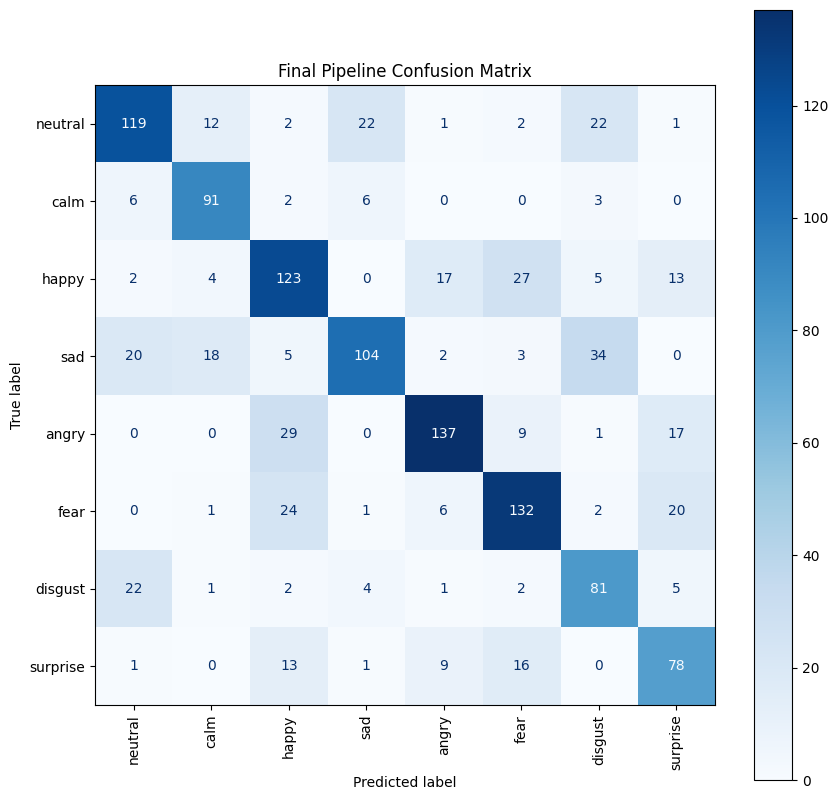

In [27]:
# This is the prediction function that uses your full pipeline
def predict_from_features(features):
    features = features.reshape(1, -1)
    scaled_features_router = scaler.transform(features)
    energy_pred_encoded = router_model.predict(scaled_features_router)[0]
    energy_pred_text = encoder.classes_[energy_pred_encoded]
    if energy_pred_text == 'high':
        scaled_features_specialist = scaler_h.transform(features)
        reshaped_features = scaled_features_specialist.reshape(1, -1, 1)
        final_pred_encoded = np.argmax(specialist_high.predict(reshaped_features, verbose=0))
        final_emotion = le_high.classes_[final_pred_encoded]
    else:
        scaled_features_specialist = scaler_l.transform(features)
        reshaped_features = scaled_features_specialist.reshape(1, -1, 1)
        final_pred_encoded = np.argmax(specialist_low.predict(reshaped_features, verbose=0))
        final_emotion = le_low.classes_[final_pred_encoded]
    return final_emotion

# --- Run Predictions on the Entire Test Set ---
# y_test_raw contains the true text labels for your test set
true_labels = y_test_raw
predictions = []

print("Running final evaluation on the test set...")
for i in tqdm(range(len(X_test))):
    feature_vector = X_test[i]
    prediction = predict_from_features(feature_vector)
    predictions.append(prediction)

# --- Generate the Final Report and Confusion Matrix ---
print("\n" + "="*40)
print("## Final Pipeline Classification Report ##")
print("="*40 + "\n")
print(classification_report(true_labels, predictions))

print("\n" + "="*40)
print("## Final Pipeline Confusion Matrix ##")
print("="*40 + "\n")
cm = confusion_matrix(true_labels, predictions, labels=df['label'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['label'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Final Pipeline Confusion Matrix')
plt.show()